In [645]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/st-2-ml-bootcamp/sample_submission.csv
/kaggle/input/st-2-ml-bootcamp/train.csv
/kaggle/input/st-2-ml-bootcamp/test.csv


**Импортирую библиотеки**

In [646]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

In [647]:
train = pd.read_csv('/kaggle/input/st-2-ml-bootcamp/train.csv')
test = pd.read_csv('/kaggle/input/st-2-ml-bootcamp/test.csv')
sampl = pd.read_csv('/kaggle/input/st-2-ml-bootcamp/sample_submission.csv')

In [648]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [649]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [650]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Создаю новый столбец с группами пассажиров из столбца их Id

In [651]:
def pass_id(df):
    df[['PassengerId','PassengerGroup']] = df['PassengerId'].str.split('_',expand=True)
    return df

Создаю новые столбцы Deck, Num, Side из столбца Cabin

In [652]:
def cabin(df): 
    df[['Deck','Num','Side']] = df['Cabin'].str.split('/',expand=True)
    return df

Привожу нужные столбцы к boolean типу

In [653]:
def to_bool(df):
    df['VIP'] = df['VIP'].astype("boolean")
    df['CryoSleep'] = df['CryoSleep'].astype("boolean")
    
    return df

Применяю все функции до и удаляю столбцы Имени и Кабины

In [654]:
def conv(df):
    df = pass_id(df)
    df = to_bool(df)
    df = cabin(df)
    df= df.drop(columns=['Name','Cabin'])
    return df

In [655]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Денежные значения заполняю нулями где нужно, создаю новый столбец с суммой потраченных денег на пассажира, значения VIP заполняю наиболее частым False, CryoSleep заполняю True, если пассажир что либо покупал, иначе False

In [656]:
def bool_null(df):
    df['RoomService'] = df['RoomService'].fillna(0)
    df['RoomService'] = df['RoomService'].astype(float)
    df['FoodCourt'] = df['FoodCourt'].fillna(0)
    df['FoodCourt'] = df['FoodCourt'].astype(float)
    df['ShoppingMall'] = df['ShoppingMall'].fillna(0)
    df['ShoppingMall'] = df['ShoppingMall'].astype(float)
    df['Spa'] = df['Spa'].fillna(0)
    df['Spa'] = df['Spa'].astype(float)
    df['VRDeck'] = df['VRDeck'].fillna(0)
    df['VRDeck'] = df['VRDeck'].astype(float)
    df['TotalBill'] = df['RoomService']+ df['FoodCourt']+ df['ShoppingMall']+ df['Spa']+ df['VRDeck']
    df['VIP'] = df['VIP'].fillna(False)
    df['CryoSleep'] = np.where(df['CryoSleep'].isna(),df['TotalBill'] == 0, df['CryoSleep'])
    return df

Значения столбцов Deck, Side, Destination, HomePlanet заполняю модой по группе их пассажиров, если они одни - заполняю модой по всему столбцу. Num заполняю просто его модой.

In [657]:
def null_group(df):
    df['Deck'] = df.groupby('PassengerGroup')['Deck'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    df['Side'] = df.groupby('PassengerGroup')['Side'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    df['Num'] = df['Num'].fillna(df['Num'].mode()[0])
    df['Destination'] = df.groupby('PassengerGroup')['Destination'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    df['HomePlanet'] = df.groupby('PassengerGroup')['HomePlanet'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    return df

Возраст заполняю средним

In [658]:
def null_age(df):
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    return df

Много значений, добавляю столбец с группами возраста

In [659]:
def age(df):
    df['AgeGroup'] = pd.qcut(df['Age'], q = 4, labels=['Baby','Young','Middle','Old'])
    return df

Все применяю

In [660]:
def null_out(df):
    df = null_age(df)
    df = null_group(df)
    df = bool_null(df)
    df = age(df)
    return df

In [661]:
def met(df):
    df = conv(df)
    df = null_out(df)
    return df

In [662]:
train = met(train)

In [663]:
train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
PassengerGroup    0
Deck              0
Num               0
Side              0
TotalBill         0
AgeGroup          0
dtype: int64

Корелляция численных столбцов

In [664]:
corr = train.drop(columns=['PassengerId', 'Deck', 'Num','Side', 'HomePlanet', 'Destination','AgeGroup']).corr()
corr

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,TotalBill
CryoSleep,1.000000,-0.077286,-0.081318,-0.250173,-0.211061,-0.212977,-0.203249,-0.197524,0.467230,0.067217,-0.386081
Age,-0.077286,1.000000,0.091574,0.068425,0.127343,0.032846,0.121071,0.099551,-0.074249,-0.131425,0.184524
VIP,-0.081318,0.091574,1.000000,0.056566,0.125499,0.018412,0.060991,0.123061,-0.037261,0.000703,0.162987
RoomService,-0.250173,0.068425,0.056566,1.000000,-0.015126,0.052337,0.009244,-0.018624,-0.241124,-0.021750,0.234374
FoodCourt,-0.211061,0.127343,0.125499,-0.015126,1.000000,-0.013717,0.221468,0.224572,0.045583,0.023265,0.742608
ShoppingMall,-0.212977,0.032846,0.018412,0.052337,-0.013717,1.000000,0.014542,-0.007849,0.009391,-0.038582,0.220529
Spa,-0.203249,0.121071,0.060991,0.009244,0.221468,0.014542,1.000000,0.147658,-0.218545,0.016767,0.592656
VRDeck,-0.197524,0.099551,0.123061,-0.018624,0.224572,-0.007849,0.147658,1.000000,-0.204874,0.009686,0.585684
Transported,0.467230,-0.074249,-0.037261,-0.241124,0.045583,0.009391,-0.218545,-0.204874,1.000000,0.066390,-0.199514
PassengerGroup,0.067217,-0.131425,0.000703,-0.021750,0.023265,-0.038582,0.016767,0.009686,0.066390,1.000000,0.010540


<Axes: >

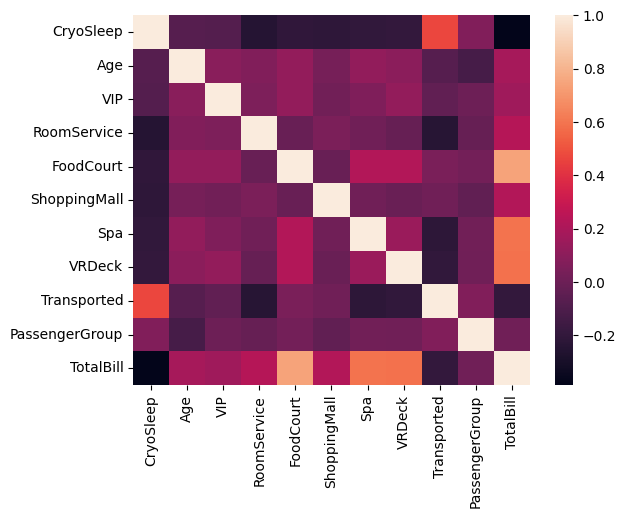

In [665]:
sns.heatmap(corr)

Смотрю значения Deck, Num, Side, PassengerGroup

<Axes: xlabel='Deck', ylabel='count'>

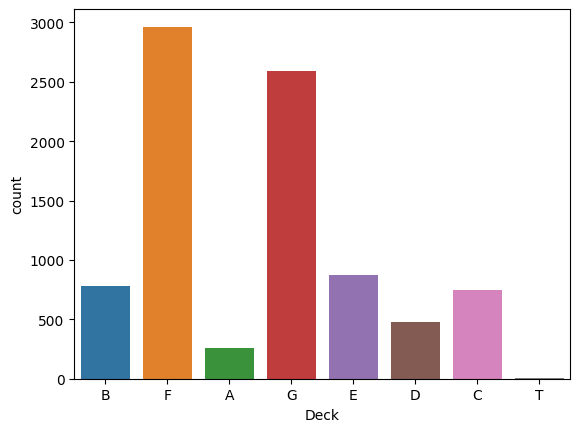

In [666]:
sns.countplot(data=train, x='Deck')

<Axes: xlabel='Num', ylabel='count'>

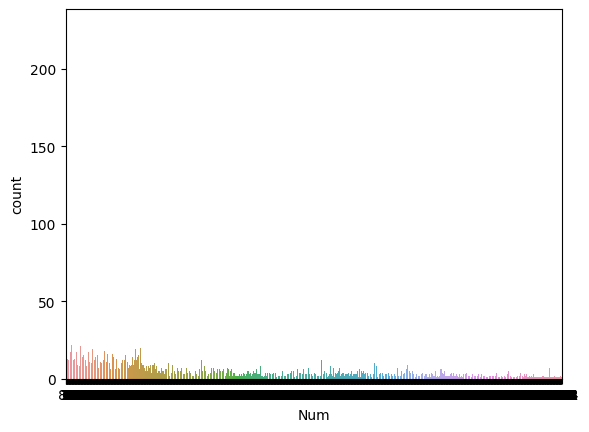

In [667]:
sns.countplot(data=train, x='Num')

Num очень много, делю на группы 

In [668]:
train['Num'] = pd.cut(train['Num'].astype(int),bins=5,labels=[1,2,3,4,5])

<Axes: xlabel='Side', ylabel='count'>

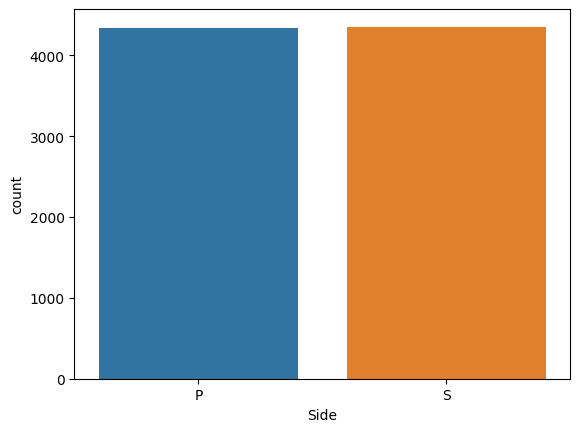

In [669]:
sns.countplot(data=train, x='Side')

<Axes: xlabel='PassengerGroup', ylabel='count'>

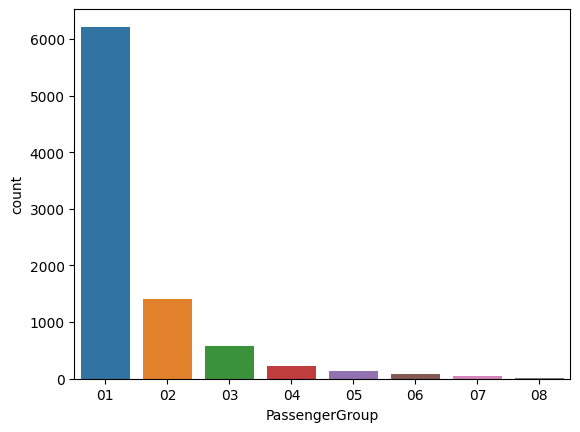

In [670]:
sns.countplot(data=train, x='PassengerGroup')

<Axes: xlabel='PassengerGroup', ylabel='Transported'>

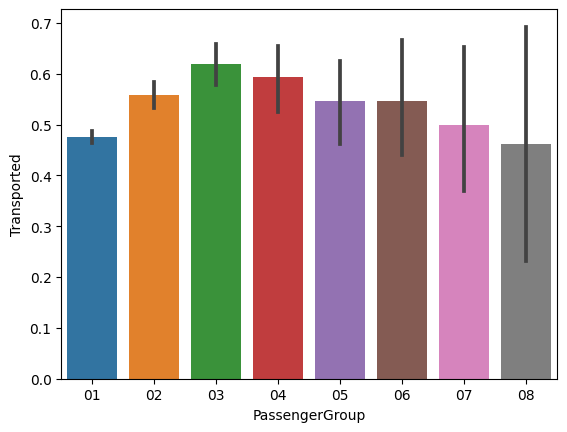

In [671]:
sns.barplot(data=train,x='PassengerGroup',y='Transported')

PassengeerGroup тоже немного группирую

In [672]:
train['PassengerGroup'] = pd.cut(train['PassengerGroup'].astype(int),bins=4,labels=[1,2,3,4])

Смотрю графики

<Axes: xlabel='Deck', ylabel='Transported'>

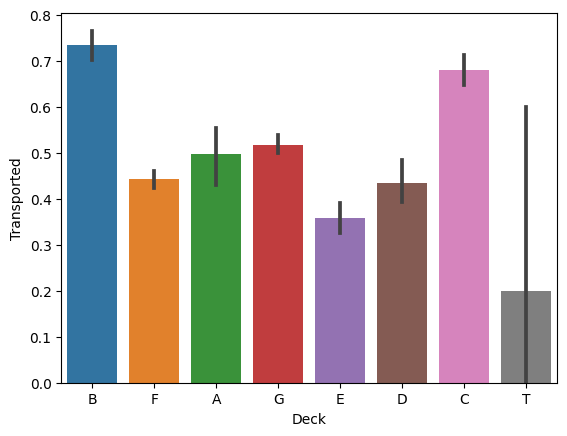

In [673]:
sns.barplot(data=train,x='Deck',y='Transported')

<Axes: xlabel='Side', ylabel='Transported'>

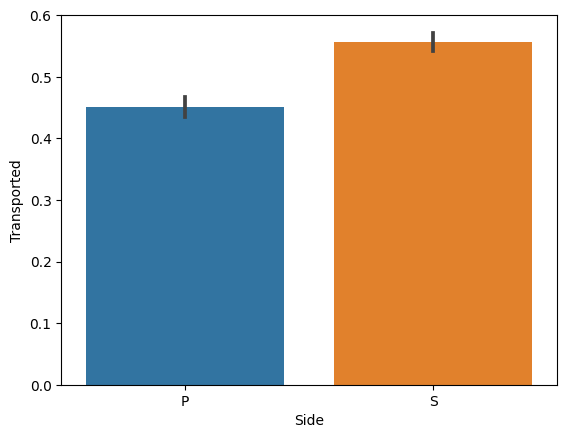

In [674]:
sns.barplot(data=train,x='Side',y='Transported')

Удаляю Id Пассажиров

In [675]:
train = train.drop(columns=['PassengerId'])

Формирую признаки и таргет, делаю полиномиальные фичи


In [676]:
X = train.drop(columns=['Transported'])
y = train['Transported']
poly = PolynomialFeatures(degree=3,include_bias=False)

Стандартизирую численные признаки, кодирую котегориальные

In [677]:
prepr = ColumnTransformer(transformers=[('n',StandardScaler(),['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalBill']),('b','passthrough',['CryoSleep','VIP']),('c',OrdinalEncoder(),['HomePlanet','Destination','PassengerGroup','Num','AgeGroup','Side','Deck'])])

In [678]:
X = prepr.fit_transform(X)
X = poly.fit_transform(X)

Модель Градиентного бустинга

In [679]:
model = lgb.LGBMClassifier(n_estimators=195,learning_rate=0.05,max_depth=9,num_leaves=31,reg_alpha=0.1,reg_lambda=0.1,min_child_samples=20,min_split_gain=0.001,subsample=0.8,colsample_bytree=0.8,n_jobs=-1,verbosity=-1)

Обучаю модель

In [680]:
model.fit(X,y)


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=9,
               min_split_gain=0.001, n_estimators=195, n_jobs=-1, reg_alpha=0.1,
               reg_lambda=0.05, subsample=0.8, verbosity=-1)

С тестовой выборкой все тоже самое, что и с тренировочной

In [681]:
test = met(test)
test = test.drop(columns=['PassengerId'])
test['Num'] = pd.cut(test['Num'].astype(int),bins=5,labels=[1,2,3,4,5])
test['PassengerGroup'] = pd.cut(test['PassengerGroup'].astype(int),bins=4,labels=[1,2,3,4])
test = prepr.transform(test)
test = poly.transform(test)

Делаю предикт

In [682]:
y_t = model.predict(test)
y_t = y_t.astype("bool")

Отправляю решение

In [683]:
submission = pd.DataFrame({'PassengerId': list(sampl['PassengerId']),'Transported':y_t})

In [684]:
submission.to_csv('/kaggle/working/submission.csv', index=False)